# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 7.34KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

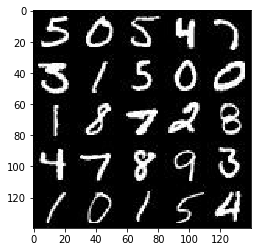

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

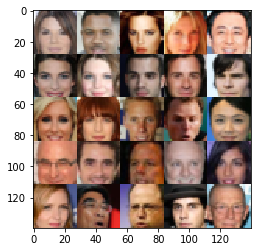

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, 2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, 2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)

        # Reshape it to start the convulational stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            d_loss, var_list=d_vars
        )
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            g_loss, var_list=g_vars
        )
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                        input_real: batch_images, input_z: batch_z, learn_rate: learning_rate
                    }
                )
                
                _ = sess.run(g_opt, feed_dict={
                        input_real: batch_images, input_z: batch_z, learn_rate: learning_rate
                    }
                )
                
                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.8258... Generator Loss: 0.8676
Epoch 0/2... Discriminator Loss: 0.3562... Generator Loss: 1.5572
Epoch 0/2... Discriminator Loss: 0.3940... Generator Loss: 1.6654
Epoch 0/2... Discriminator Loss: 0.3338... Generator Loss: 1.7446


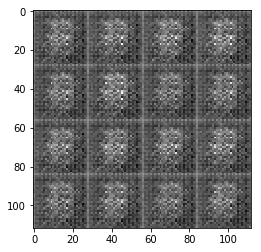

Epoch 0/2... Discriminator Loss: 0.5392... Generator Loss: 3.2060
Epoch 0/2... Discriminator Loss: 1.4509... Generator Loss: 0.3147
Epoch 0/2... Discriminator Loss: 0.4820... Generator Loss: 2.3766
Epoch 0/2... Discriminator Loss: 0.4696... Generator Loss: 2.2438
Epoch 0/2... Discriminator Loss: 0.2869... Generator Loss: 2.5396


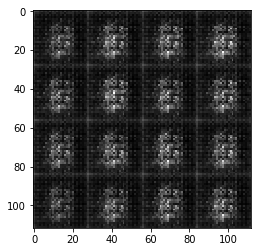

Epoch 0/2... Discriminator Loss: 0.8074... Generator Loss: 0.8734
Epoch 0/2... Discriminator Loss: 0.3171... Generator Loss: 1.9375
Epoch 0/2... Discriminator Loss: 0.8641... Generator Loss: 0.6643
Epoch 0/2... Discriminator Loss: 0.3840... Generator Loss: 1.8789
Epoch 0/2... Discriminator Loss: 0.1973... Generator Loss: 2.7368


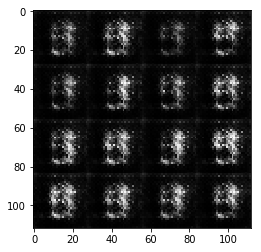

Epoch 0/2... Discriminator Loss: 0.3913... Generator Loss: 2.0957
Epoch 0/2... Discriminator Loss: 0.2530... Generator Loss: 3.4346
Epoch 0/2... Discriminator Loss: 0.2532... Generator Loss: 2.4746
Epoch 0/2... Discriminator Loss: 0.1678... Generator Loss: 2.5514
Epoch 0/2... Discriminator Loss: 0.4287... Generator Loss: 1.6413


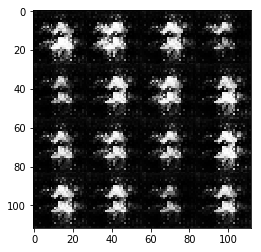

Epoch 0/2... Discriminator Loss: 0.2950... Generator Loss: 2.3264
Epoch 0/2... Discriminator Loss: 0.3658... Generator Loss: 2.2192
Epoch 0/2... Discriminator Loss: 0.0967... Generator Loss: 3.3700
Epoch 0/2... Discriminator Loss: 0.1071... Generator Loss: 3.1682
Epoch 0/2... Discriminator Loss: 0.0651... Generator Loss: 3.5368


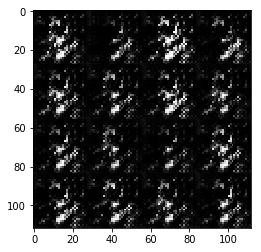

Epoch 0/2... Discriminator Loss: 0.1908... Generator Loss: 2.4613
Epoch 0/2... Discriminator Loss: 0.1550... Generator Loss: 2.8286
Epoch 0/2... Discriminator Loss: 0.1829... Generator Loss: 2.8434
Epoch 0/2... Discriminator Loss: 0.2409... Generator Loss: 2.2124
Epoch 0/2... Discriminator Loss: 0.2172... Generator Loss: 2.4995


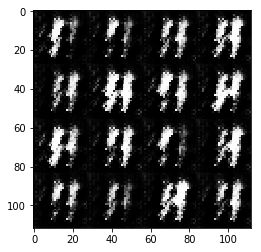

Epoch 0/2... Discriminator Loss: 0.1851... Generator Loss: 2.5656
Epoch 0/2... Discriminator Loss: 0.3496... Generator Loss: 2.0065
Epoch 0/2... Discriminator Loss: 0.3838... Generator Loss: 1.7368
Epoch 0/2... Discriminator Loss: 0.3195... Generator Loss: 1.8654
Epoch 0/2... Discriminator Loss: 0.2387... Generator Loss: 2.9214


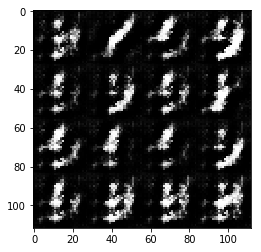

Epoch 0/2... Discriminator Loss: 0.2041... Generator Loss: 2.4127
Epoch 0/2... Discriminator Loss: 0.2432... Generator Loss: 2.8417
Epoch 0/2... Discriminator Loss: 0.1672... Generator Loss: 3.4345
Epoch 0/2... Discriminator Loss: 0.3118... Generator Loss: 3.1656
Epoch 0/2... Discriminator Loss: 0.1312... Generator Loss: 3.2250


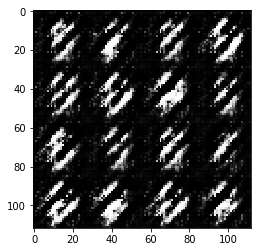

Epoch 0/2... Discriminator Loss: 0.3635... Generator Loss: 2.0135
Epoch 0/2... Discriminator Loss: 0.2668... Generator Loss: 2.3113
Epoch 0/2... Discriminator Loss: 0.3703... Generator Loss: 1.7568
Epoch 0/2... Discriminator Loss: 0.1672... Generator Loss: 2.6132
Epoch 0/2... Discriminator Loss: 0.2408... Generator Loss: 3.4935


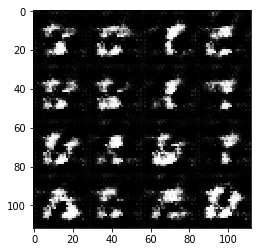

Epoch 0/2... Discriminator Loss: 0.3674... Generator Loss: 1.5947
Epoch 0/2... Discriminator Loss: 0.5988... Generator Loss: 1.4116
Epoch 0/2... Discriminator Loss: 0.2136... Generator Loss: 3.0021
Epoch 0/2... Discriminator Loss: 0.1759... Generator Loss: 2.8985
Epoch 0/2... Discriminator Loss: 0.5128... Generator Loss: 1.4672


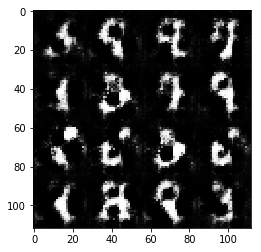

Epoch 0/2... Discriminator Loss: 0.4567... Generator Loss: 2.2344
Epoch 0/2... Discriminator Loss: 0.2252... Generator Loss: 2.5646
Epoch 0/2... Discriminator Loss: 0.4277... Generator Loss: 1.4379
Epoch 0/2... Discriminator Loss: 0.2504... Generator Loss: 2.3326
Epoch 0/2... Discriminator Loss: 0.2869... Generator Loss: 2.3347


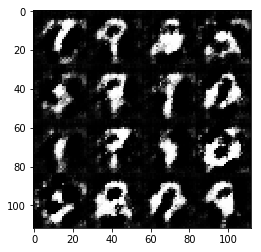

Epoch 0/2... Discriminator Loss: 0.2628... Generator Loss: 2.7465
Epoch 0/2... Discriminator Loss: 0.4136... Generator Loss: 2.2164
Epoch 0/2... Discriminator Loss: 0.2674... Generator Loss: 2.9051
Epoch 0/2... Discriminator Loss: 0.3316... Generator Loss: 2.5811
Epoch 0/2... Discriminator Loss: 0.4411... Generator Loss: 2.4378


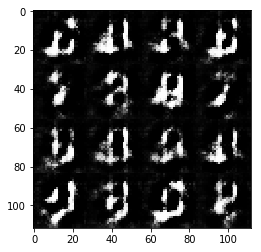

Epoch 0/2... Discriminator Loss: 0.3074... Generator Loss: 2.8240
Epoch 0/2... Discriminator Loss: 0.5619... Generator Loss: 1.6998
Epoch 0/2... Discriminator Loss: 0.2770... Generator Loss: 4.2214
Epoch 0/2... Discriminator Loss: 0.5546... Generator Loss: 1.3875
Epoch 0/2... Discriminator Loss: 0.3181... Generator Loss: 2.2266


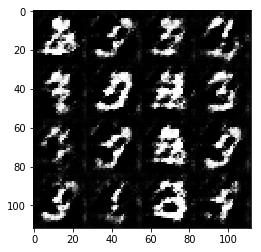

Epoch 0/2... Discriminator Loss: 0.3833... Generator Loss: 2.1261
Epoch 0/2... Discriminator Loss: 0.3102... Generator Loss: 1.9692
Epoch 0/2... Discriminator Loss: 0.5910... Generator Loss: 1.3506
Epoch 0/2... Discriminator Loss: 0.6315... Generator Loss: 3.4831
Epoch 0/2... Discriminator Loss: 0.4402... Generator Loss: 2.8068


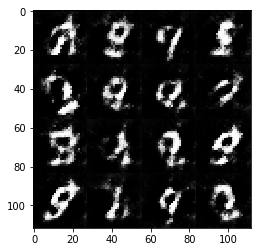

Epoch 0/2... Discriminator Loss: 0.5478... Generator Loss: 1.6018
Epoch 0/2... Discriminator Loss: 0.2903... Generator Loss: 2.6486
Epoch 0/2... Discriminator Loss: 0.3647... Generator Loss: 1.7840
Epoch 0/2... Discriminator Loss: 0.4491... Generator Loss: 2.1000
Epoch 0/2... Discriminator Loss: 0.6745... Generator Loss: 2.6672


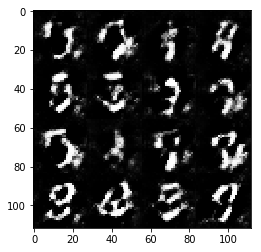

Epoch 0/2... Discriminator Loss: 0.3134... Generator Loss: 2.4795
Epoch 0/2... Discriminator Loss: 0.4416... Generator Loss: 2.1333
Epoch 0/2... Discriminator Loss: 0.5191... Generator Loss: 3.0744
Epoch 0/2... Discriminator Loss: 0.3664... Generator Loss: 1.9050
Epoch 0/2... Discriminator Loss: 1.1626... Generator Loss: 4.5531


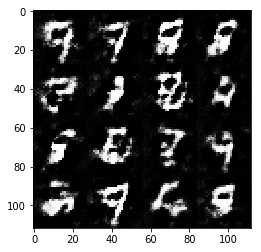

Epoch 0/2... Discriminator Loss: 0.4678... Generator Loss: 1.6446
Epoch 0/2... Discriminator Loss: 0.5036... Generator Loss: 1.6056
Epoch 0/2... Discriminator Loss: 0.4016... Generator Loss: 2.1232
Epoch 0/2... Discriminator Loss: 0.4534... Generator Loss: 1.9727
Epoch 0/2... Discriminator Loss: 0.9016... Generator Loss: 0.7958


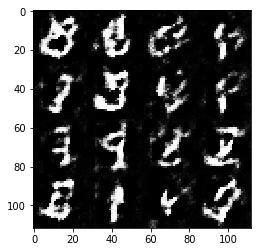

Epoch 0/2... Discriminator Loss: 0.4129... Generator Loss: 1.7479
Epoch 0/2... Discriminator Loss: 0.6295... Generator Loss: 1.4400
Epoch 0/2... Discriminator Loss: 0.4318... Generator Loss: 1.8005
Epoch 0/2... Discriminator Loss: 0.6257... Generator Loss: 1.1717
Epoch 0/2... Discriminator Loss: 0.6916... Generator Loss: 1.0500


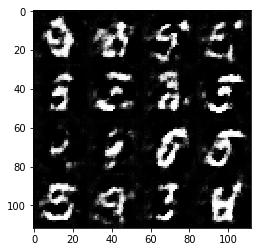

Epoch 0/2... Discriminator Loss: 0.4928... Generator Loss: 2.5755
Epoch 0/2... Discriminator Loss: 0.4521... Generator Loss: 1.7285
Epoch 0/2... Discriminator Loss: 0.4156... Generator Loss: 2.5041
Epoch 0/2... Discriminator Loss: 0.4337... Generator Loss: 2.3625
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 4.1036


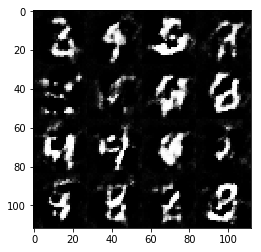

Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 1.7693
Epoch 1/2... Discriminator Loss: 0.7108... Generator Loss: 1.3319
Epoch 1/2... Discriminator Loss: 0.4410... Generator Loss: 2.0406
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.5127
Epoch 1/2... Discriminator Loss: 0.5897... Generator Loss: 1.1854


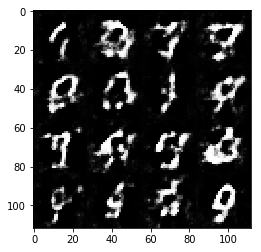

Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 4.3969
Epoch 1/2... Discriminator Loss: 0.4820... Generator Loss: 1.9796
Epoch 1/2... Discriminator Loss: 0.7193... Generator Loss: 3.1345
Epoch 1/2... Discriminator Loss: 0.4583... Generator Loss: 2.4203
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 3.2658


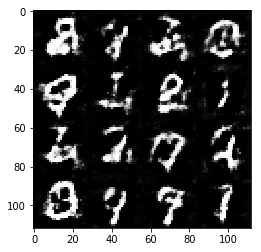

Epoch 1/2... Discriminator Loss: 0.5720... Generator Loss: 1.3962
Epoch 1/2... Discriminator Loss: 0.4992... Generator Loss: 1.7158
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 2.4737
Epoch 1/2... Discriminator Loss: 0.4533... Generator Loss: 1.7615
Epoch 1/2... Discriminator Loss: 0.4925... Generator Loss: 1.5120


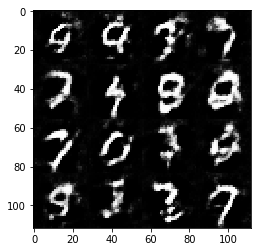

Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 3.3049
Epoch 1/2... Discriminator Loss: 0.6180... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 0.4899... Generator Loss: 1.6649
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 2.1131
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 3.6767


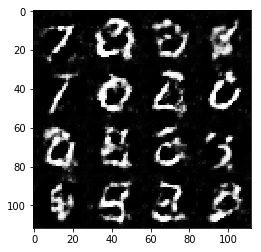

Epoch 1/2... Discriminator Loss: 0.4665... Generator Loss: 1.6718
Epoch 1/2... Discriminator Loss: 0.5152... Generator Loss: 1.4382
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 0.4859... Generator Loss: 1.3556
Epoch 1/2... Discriminator Loss: 0.6095... Generator Loss: 1.9254


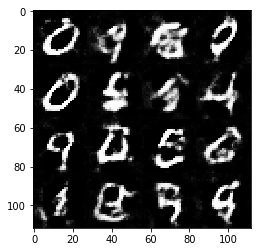

Epoch 1/2... Discriminator Loss: 0.5263... Generator Loss: 1.6845
Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 2.3324
Epoch 1/2... Discriminator Loss: 0.5487... Generator Loss: 1.4112
Epoch 1/2... Discriminator Loss: 0.5974... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 0.5187... Generator Loss: 1.4503


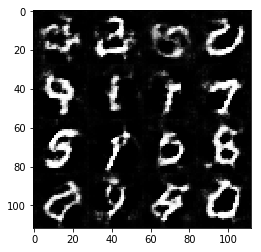

Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 1.1457
Epoch 1/2... Discriminator Loss: 0.4850... Generator Loss: 1.5902
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 1.1712... Generator Loss: 3.7895
Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 1.7008


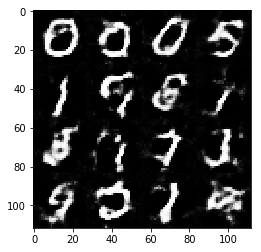

Epoch 1/2... Discriminator Loss: 0.7825... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 1.1699
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 1.2826
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.0550


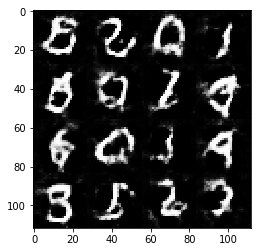

Epoch 1/2... Discriminator Loss: 0.5543... Generator Loss: 1.9808
Epoch 1/2... Discriminator Loss: 0.4967... Generator Loss: 2.2259
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 0.7808
Epoch 1/2... Discriminator Loss: 0.5253... Generator Loss: 1.4847
Epoch 1/2... Discriminator Loss: 0.4553... Generator Loss: 1.8866


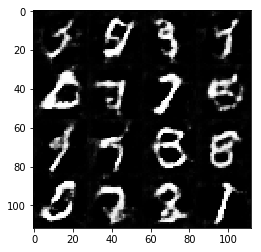

Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 1.7768
Epoch 1/2... Discriminator Loss: 0.7206... Generator Loss: 1.1205
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 1.3007
Epoch 1/2... Discriminator Loss: 0.8883... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 1.9759


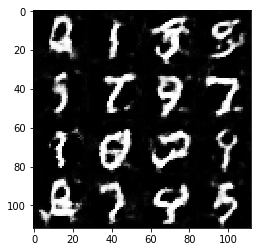

Epoch 1/2... Discriminator Loss: 0.5436... Generator Loss: 1.3751
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 2.9597
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 2.3036
Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 1.6204
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 1.1212


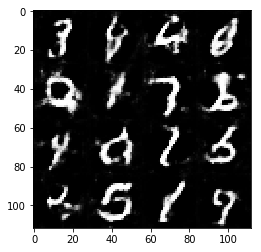

Epoch 1/2... Discriminator Loss: 0.7532... Generator Loss: 1.9817
Epoch 1/2... Discriminator Loss: 0.7089... Generator Loss: 2.2801
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 0.9271
Epoch 1/2... Discriminator Loss: 0.4733... Generator Loss: 1.6059
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 1.1320


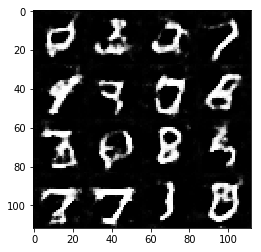

Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 1.2864
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 0.5310... Generator Loss: 1.4799
Epoch 1/2... Discriminator Loss: 0.5641... Generator Loss: 1.2444
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 2.7178


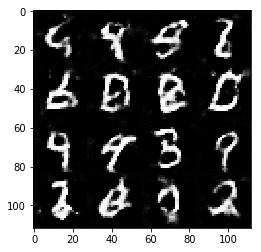

Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 1.0974
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 1.7567
Epoch 1/2... Discriminator Loss: 0.7046... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 0.6690... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 2.9681


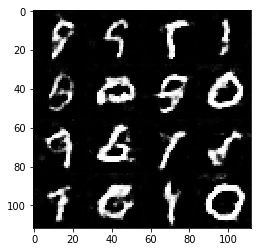

Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 1.4415
Epoch 1/2... Discriminator Loss: 0.5965... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 1.1830
Epoch 1/2... Discriminator Loss: 0.6222... Generator Loss: 1.1412


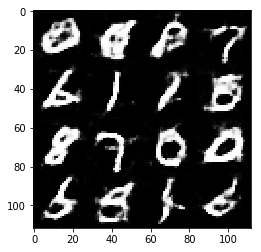

Epoch 1/2... Discriminator Loss: 0.4572... Generator Loss: 2.0375
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 1.5258
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 0.5253
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 0.6333


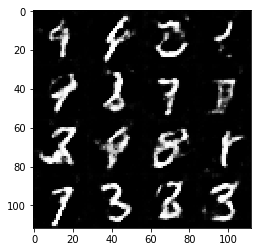

Epoch 1/2... Discriminator Loss: 0.5447... Generator Loss: 1.6265
Epoch 1/2... Discriminator Loss: 0.5854... Generator Loss: 2.2807
Epoch 1/2... Discriminator Loss: 0.6778... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 0.6384... Generator Loss: 1.6715
Epoch 1/2... Discriminator Loss: 0.5960... Generator Loss: 1.6560


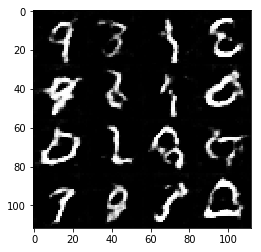

Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 2.7776
Epoch 1/2... Discriminator Loss: 0.8234... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 1.3272
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 2.5124
Epoch 1/2... Discriminator Loss: 1.0737... Generator Loss: 3.0998


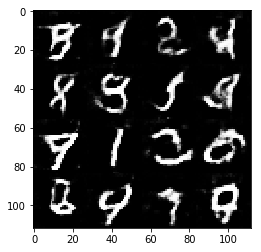

Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.6934
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 0.5972... Generator Loss: 1.1735


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/2... Discriminator Loss: 0.1258... Generator Loss: 7.2698
Epoch 0/2... Discriminator Loss: 0.2034... Generator Loss: 16.3840
Epoch 0/2... Discriminator Loss: 0.4767... Generator Loss: 14.7500
Epoch 0/2... Discriminator Loss: 0.0864... Generator Loss: 9.8660


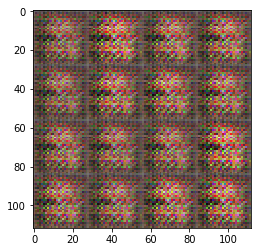

Epoch 0/2... Discriminator Loss: 4.0110... Generator Loss: 0.0199
Epoch 0/2... Discriminator Loss: 0.1347... Generator Loss: 5.3348
Epoch 0/2... Discriminator Loss: 1.4445... Generator Loss: 0.3222
Epoch 0/2... Discriminator Loss: 2.1560... Generator Loss: 0.2936
Epoch 0/2... Discriminator Loss: 1.0992... Generator Loss: 4.1733


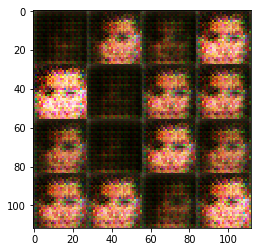

Epoch 0/2... Discriminator Loss: 0.8135... Generator Loss: 4.8336
Epoch 0/2... Discriminator Loss: 0.4524... Generator Loss: 1.2752
Epoch 0/2... Discriminator Loss: 0.4030... Generator Loss: 2.4400
Epoch 0/2... Discriminator Loss: 0.6107... Generator Loss: 1.8134
Epoch 0/2... Discriminator Loss: 1.2257... Generator Loss: 0.6134


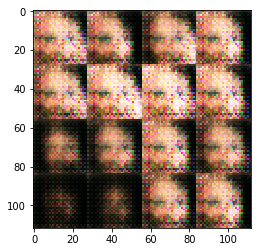

Epoch 0/2... Discriminator Loss: 0.6613... Generator Loss: 1.3516
Epoch 0/2... Discriminator Loss: 0.8119... Generator Loss: 1.0198
Epoch 0/2... Discriminator Loss: 1.6229... Generator Loss: 0.4615
Epoch 0/2... Discriminator Loss: 0.7720... Generator Loss: 3.8725
Epoch 0/2... Discriminator Loss: 0.9056... Generator Loss: 0.9743


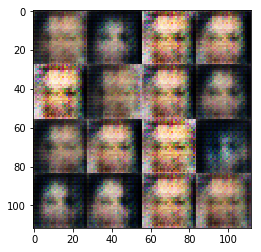

Epoch 0/2... Discriminator Loss: 1.4515... Generator Loss: 1.0169
Epoch 0/2... Discriminator Loss: 1.3980... Generator Loss: 0.5965
Epoch 0/2... Discriminator Loss: 1.7539... Generator Loss: 0.5726
Epoch 0/2... Discriminator Loss: 1.2665... Generator Loss: 0.9059
Epoch 0/2... Discriminator Loss: 1.1991... Generator Loss: 0.8299


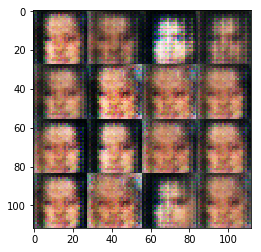

Epoch 0/2... Discriminator Loss: 1.5715... Generator Loss: 0.4799
Epoch 0/2... Discriminator Loss: 0.9545... Generator Loss: 1.1305
Epoch 0/2... Discriminator Loss: 1.1831... Generator Loss: 0.9590
Epoch 0/2... Discriminator Loss: 0.9502... Generator Loss: 1.0650
Epoch 0/2... Discriminator Loss: 1.0775... Generator Loss: 0.9187


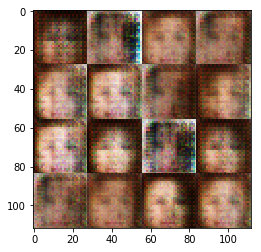

Epoch 0/2... Discriminator Loss: 1.2576... Generator Loss: 0.6965
Epoch 0/2... Discriminator Loss: 1.7116... Generator Loss: 0.8065
Epoch 0/2... Discriminator Loss: 1.1332... Generator Loss: 0.9021
Epoch 0/2... Discriminator Loss: 1.2435... Generator Loss: 1.0975
Epoch 0/2... Discriminator Loss: 0.9390... Generator Loss: 1.3715


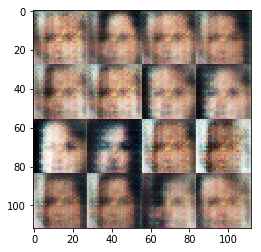

Epoch 0/2... Discriminator Loss: 0.7798... Generator Loss: 1.6481
Epoch 0/2... Discriminator Loss: 1.3733... Generator Loss: 3.1836
Epoch 0/2... Discriminator Loss: 1.0319... Generator Loss: 0.8539
Epoch 0/2... Discriminator Loss: 0.7845... Generator Loss: 1.5801
Epoch 0/2... Discriminator Loss: 0.7658... Generator Loss: 0.9927


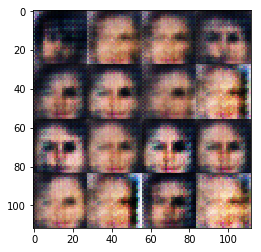

Epoch 0/2... Discriminator Loss: 1.0340... Generator Loss: 0.8045
Epoch 0/2... Discriminator Loss: 1.1054... Generator Loss: 0.6387
Epoch 0/2... Discriminator Loss: 1.0173... Generator Loss: 1.6859
Epoch 0/2... Discriminator Loss: 1.3029... Generator Loss: 1.1652
Epoch 0/2... Discriminator Loss: 1.1752... Generator Loss: 1.3601


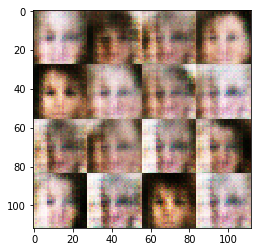

Epoch 0/2... Discriminator Loss: 1.1391... Generator Loss: 1.3010
Epoch 0/2... Discriminator Loss: 0.9922... Generator Loss: 1.5875
Epoch 0/2... Discriminator Loss: 0.9702... Generator Loss: 1.0861
Epoch 0/2... Discriminator Loss: 1.2668... Generator Loss: 1.5072
Epoch 0/2... Discriminator Loss: 0.7328... Generator Loss: 1.5868


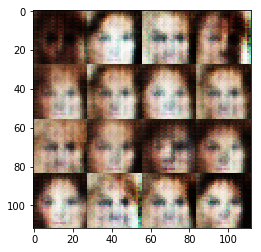

Epoch 0/2... Discriminator Loss: 0.8645... Generator Loss: 1.3705
Epoch 0/2... Discriminator Loss: 1.2200... Generator Loss: 2.7006
Epoch 0/2... Discriminator Loss: 0.9402... Generator Loss: 1.8401
Epoch 0/2... Discriminator Loss: 1.0546... Generator Loss: 1.1046
Epoch 0/2... Discriminator Loss: 0.9083... Generator Loss: 1.0800


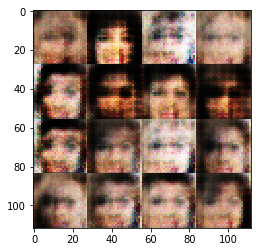

Epoch 0/2... Discriminator Loss: 0.9020... Generator Loss: 2.6153
Epoch 0/2... Discriminator Loss: 1.1366... Generator Loss: 1.7808
Epoch 0/2... Discriminator Loss: 1.3904... Generator Loss: 0.5172
Epoch 0/2... Discriminator Loss: 0.6008... Generator Loss: 1.5845
Epoch 0/2... Discriminator Loss: 1.4904... Generator Loss: 0.4167


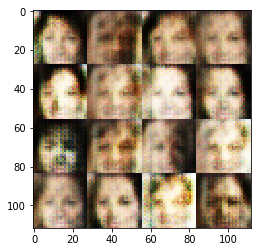

Epoch 0/2... Discriminator Loss: 1.0007... Generator Loss: 0.9286
Epoch 0/2... Discriminator Loss: 1.0512... Generator Loss: 1.0250
Epoch 0/2... Discriminator Loss: 1.0527... Generator Loss: 3.3468
Epoch 0/2... Discriminator Loss: 1.0196... Generator Loss: 0.7656
Epoch 0/2... Discriminator Loss: 1.0908... Generator Loss: 0.8342


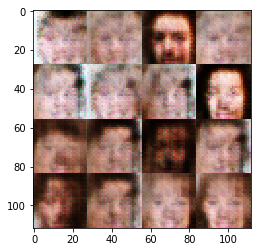

Epoch 0/2... Discriminator Loss: 0.6677... Generator Loss: 1.2404
Epoch 0/2... Discriminator Loss: 0.8367... Generator Loss: 0.8436
Epoch 0/2... Discriminator Loss: 2.1022... Generator Loss: 0.2812
Epoch 0/2... Discriminator Loss: 0.6708... Generator Loss: 1.5745
Epoch 0/2... Discriminator Loss: 0.9204... Generator Loss: 2.4176


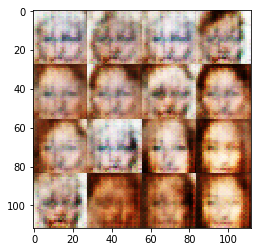

Epoch 0/2... Discriminator Loss: 0.7963... Generator Loss: 1.0244
Epoch 0/2... Discriminator Loss: 0.7151... Generator Loss: 1.3664
Epoch 0/2... Discriminator Loss: 1.1867... Generator Loss: 3.8911
Epoch 0/2... Discriminator Loss: 0.9266... Generator Loss: 1.1339
Epoch 0/2... Discriminator Loss: 0.9324... Generator Loss: 0.7551


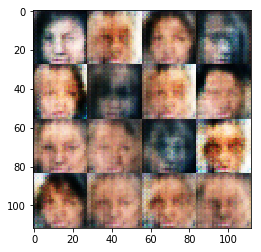

Epoch 0/2... Discriminator Loss: 0.6719... Generator Loss: 1.4803
Epoch 0/2... Discriminator Loss: 0.7184... Generator Loss: 1.6284
Epoch 0/2... Discriminator Loss: 1.1859... Generator Loss: 0.5868
Epoch 0/2... Discriminator Loss: 1.1916... Generator Loss: 0.6263
Epoch 0/2... Discriminator Loss: 0.8088... Generator Loss: 1.1239


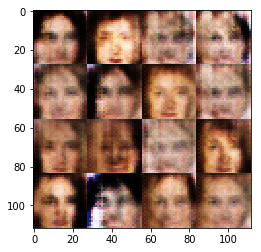

Epoch 0/2... Discriminator Loss: 1.2639... Generator Loss: 0.7464
Epoch 0/2... Discriminator Loss: 0.6738... Generator Loss: 1.2048
Epoch 0/2... Discriminator Loss: 0.7649... Generator Loss: 1.1801
Epoch 0/2... Discriminator Loss: 0.7365... Generator Loss: 1.5777
Epoch 0/2... Discriminator Loss: 0.6084... Generator Loss: 1.2088


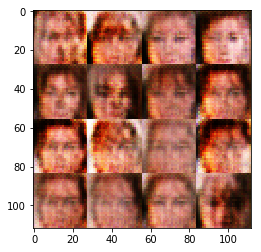

Epoch 0/2... Discriminator Loss: 1.4768... Generator Loss: 0.4565
Epoch 0/2... Discriminator Loss: 1.2811... Generator Loss: 0.7840
Epoch 0/2... Discriminator Loss: 0.7705... Generator Loss: 1.0405
Epoch 0/2... Discriminator Loss: 0.9921... Generator Loss: 1.7547
Epoch 0/2... Discriminator Loss: 1.1279... Generator Loss: 0.6625


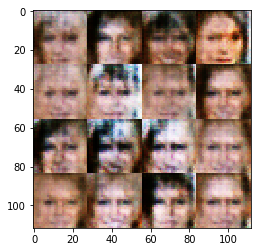

Epoch 0/2... Discriminator Loss: 0.9335... Generator Loss: 0.8226
Epoch 0/2... Discriminator Loss: 1.2529... Generator Loss: 1.0122
Epoch 0/2... Discriminator Loss: 1.1426... Generator Loss: 1.1994
Epoch 0/2... Discriminator Loss: 0.8735... Generator Loss: 1.2170
Epoch 0/2... Discriminator Loss: 1.3731... Generator Loss: 1.6202


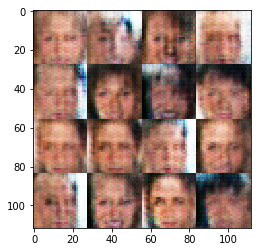

Epoch 0/2... Discriminator Loss: 0.6717... Generator Loss: 1.7823
Epoch 0/2... Discriminator Loss: 1.2396... Generator Loss: 0.7504
Epoch 0/2... Discriminator Loss: 1.2133... Generator Loss: 0.7566
Epoch 0/2... Discriminator Loss: 0.5729... Generator Loss: 1.4675
Epoch 0/2... Discriminator Loss: 0.9193... Generator Loss: 0.9739


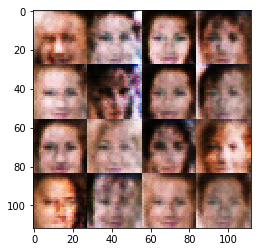

Epoch 0/2... Discriminator Loss: 0.9745... Generator Loss: 0.9120
Epoch 0/2... Discriminator Loss: 0.8193... Generator Loss: 1.1580
Epoch 0/2... Discriminator Loss: 0.9016... Generator Loss: 1.3780
Epoch 0/2... Discriminator Loss: 1.0374... Generator Loss: 1.2650
Epoch 0/2... Discriminator Loss: 1.0007... Generator Loss: 0.7727


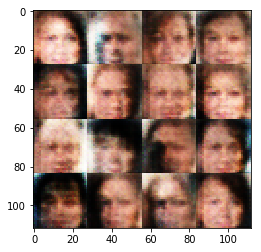

Epoch 0/2... Discriminator Loss: 1.2099... Generator Loss: 0.8084
Epoch 0/2... Discriminator Loss: 0.9835... Generator Loss: 2.1147
Epoch 0/2... Discriminator Loss: 1.1174... Generator Loss: 0.9948
Epoch 0/2... Discriminator Loss: 1.4136... Generator Loss: 0.4491
Epoch 0/2... Discriminator Loss: 1.1115... Generator Loss: 0.9305


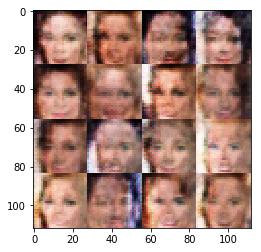

Epoch 0/2... Discriminator Loss: 0.6830... Generator Loss: 1.1550
Epoch 0/2... Discriminator Loss: 0.8332... Generator Loss: 1.2299
Epoch 0/2... Discriminator Loss: 0.8262... Generator Loss: 1.3733
Epoch 0/2... Discriminator Loss: 1.2569... Generator Loss: 0.6111
Epoch 0/2... Discriminator Loss: 1.7225... Generator Loss: 0.3126


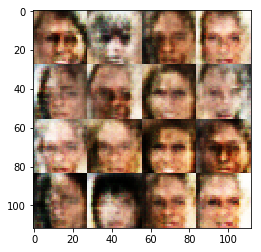

Epoch 0/2... Discriminator Loss: 0.9809... Generator Loss: 0.8804
Epoch 0/2... Discriminator Loss: 1.2163... Generator Loss: 1.4371
Epoch 0/2... Discriminator Loss: 1.0799... Generator Loss: 1.4376
Epoch 0/2... Discriminator Loss: 0.8882... Generator Loss: 1.4953
Epoch 0/2... Discriminator Loss: 1.2606... Generator Loss: 0.6129


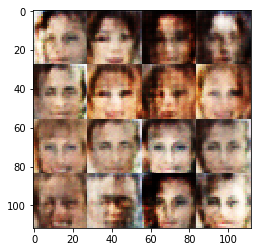

Epoch 0/2... Discriminator Loss: 1.0007... Generator Loss: 1.3926
Epoch 0/2... Discriminator Loss: 0.9095... Generator Loss: 1.3073
Epoch 0/2... Discriminator Loss: 1.5624... Generator Loss: 0.6135
Epoch 0/2... Discriminator Loss: 1.2081... Generator Loss: 0.5200
Epoch 0/2... Discriminator Loss: 0.8678... Generator Loss: 0.9557


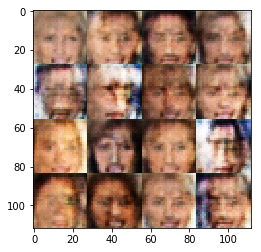

Epoch 0/2... Discriminator Loss: 0.9175... Generator Loss: 0.9671
Epoch 0/2... Discriminator Loss: 0.9731... Generator Loss: 1.5750
Epoch 0/2... Discriminator Loss: 0.8297... Generator Loss: 2.0191
Epoch 0/2... Discriminator Loss: 1.0304... Generator Loss: 0.7289
Epoch 0/2... Discriminator Loss: 0.8811... Generator Loss: 1.0005


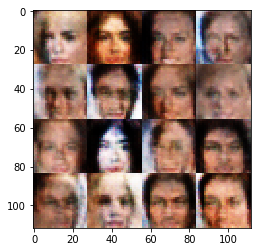

Epoch 0/2... Discriminator Loss: 1.0146... Generator Loss: 1.4286
Epoch 0/2... Discriminator Loss: 0.9211... Generator Loss: 1.0166
Epoch 0/2... Discriminator Loss: 1.0771... Generator Loss: 0.9436
Epoch 0/2... Discriminator Loss: 1.0649... Generator Loss: 1.4717
Epoch 0/2... Discriminator Loss: 1.0789... Generator Loss: 1.8666


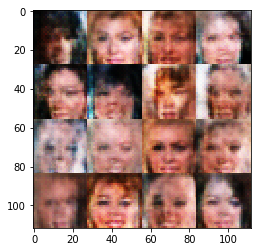

Epoch 0/2... Discriminator Loss: 1.1839... Generator Loss: 0.6059
Epoch 0/2... Discriminator Loss: 0.9229... Generator Loss: 1.0934
Epoch 0/2... Discriminator Loss: 1.2003... Generator Loss: 0.6249
Epoch 0/2... Discriminator Loss: 1.0151... Generator Loss: 0.7636
Epoch 0/2... Discriminator Loss: 0.9865... Generator Loss: 0.8109


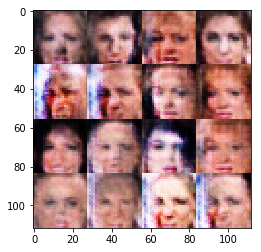

Epoch 0/2... Discriminator Loss: 1.0585... Generator Loss: 1.8298
Epoch 0/2... Discriminator Loss: 0.9020... Generator Loss: 1.1415
Epoch 0/2... Discriminator Loss: 0.8767... Generator Loss: 1.1113
Epoch 0/2... Discriminator Loss: 1.0002... Generator Loss: 0.8792
Epoch 0/2... Discriminator Loss: 1.0250... Generator Loss: 0.7950


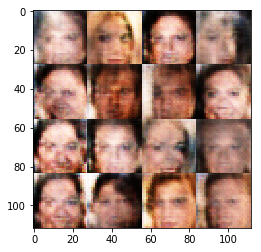

Epoch 0/2... Discriminator Loss: 1.0662... Generator Loss: 0.7060
Epoch 0/2... Discriminator Loss: 1.0109... Generator Loss: 1.1806
Epoch 0/2... Discriminator Loss: 0.7185... Generator Loss: 1.6145
Epoch 0/2... Discriminator Loss: 1.1030... Generator Loss: 1.3393
Epoch 0/2... Discriminator Loss: 1.0299... Generator Loss: 0.7103


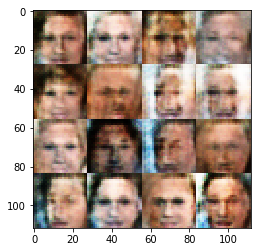

Epoch 0/2... Discriminator Loss: 0.9901... Generator Loss: 1.4433
Epoch 0/2... Discriminator Loss: 1.1528... Generator Loss: 0.7128
Epoch 0/2... Discriminator Loss: 0.7635... Generator Loss: 1.5999
Epoch 0/2... Discriminator Loss: 0.9535... Generator Loss: 1.9065
Epoch 0/2... Discriminator Loss: 1.0397... Generator Loss: 1.8174


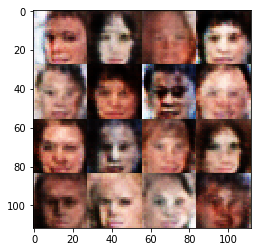

Epoch 0/2... Discriminator Loss: 0.9484... Generator Loss: 0.9671
Epoch 0/2... Discriminator Loss: 0.8459... Generator Loss: 0.8906
Epoch 0/2... Discriminator Loss: 1.3999... Generator Loss: 0.4797
Epoch 0/2... Discriminator Loss: 0.7961... Generator Loss: 1.7484
Epoch 0/2... Discriminator Loss: 0.9400... Generator Loss: 1.0400


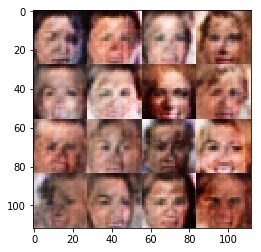

Epoch 0/2... Discriminator Loss: 0.9836... Generator Loss: 1.3105
Epoch 0/2... Discriminator Loss: 1.2255... Generator Loss: 0.5782
Epoch 0/2... Discriminator Loss: 0.9186... Generator Loss: 1.4110
Epoch 0/2... Discriminator Loss: 0.7561... Generator Loss: 1.6300
Epoch 0/2... Discriminator Loss: 0.9818... Generator Loss: 0.8080


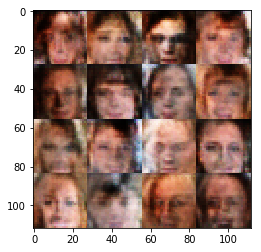

Epoch 0/2... Discriminator Loss: 1.0216... Generator Loss: 0.9104
Epoch 0/2... Discriminator Loss: 0.9603... Generator Loss: 1.7248
Epoch 0/2... Discriminator Loss: 0.7197... Generator Loss: 1.5390
Epoch 0/2... Discriminator Loss: 0.9284... Generator Loss: 1.1015
Epoch 0/2... Discriminator Loss: 0.8102... Generator Loss: 1.0067


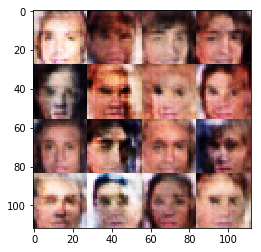

Epoch 0/2... Discriminator Loss: 1.0463... Generator Loss: 1.5865
Epoch 0/2... Discriminator Loss: 0.8949... Generator Loss: 1.2407
Epoch 0/2... Discriminator Loss: 1.0350... Generator Loss: 0.7670
Epoch 0/2... Discriminator Loss: 0.9810... Generator Loss: 0.9745
Epoch 0/2... Discriminator Loss: 0.9239... Generator Loss: 0.8526


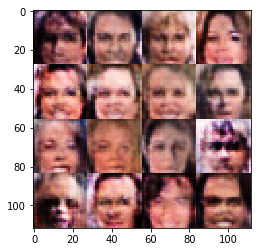

Epoch 0/2... Discriminator Loss: 1.0319... Generator Loss: 0.9043
Epoch 0/2... Discriminator Loss: 0.9630... Generator Loss: 1.0334
Epoch 0/2... Discriminator Loss: 1.4447... Generator Loss: 0.4990
Epoch 0/2... Discriminator Loss: 1.1795... Generator Loss: 0.5608
Epoch 0/2... Discriminator Loss: 0.8589... Generator Loss: 0.9543


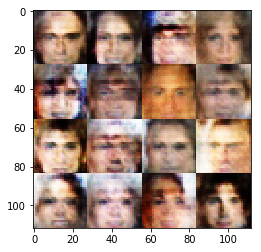

Epoch 0/2... Discriminator Loss: 1.0462... Generator Loss: 0.8125
Epoch 0/2... Discriminator Loss: 1.0152... Generator Loss: 0.9226
Epoch 0/2... Discriminator Loss: 0.8477... Generator Loss: 1.5127
Epoch 0/2... Discriminator Loss: 0.8232... Generator Loss: 1.2890
Epoch 0/2... Discriminator Loss: 1.1316... Generator Loss: 0.7844


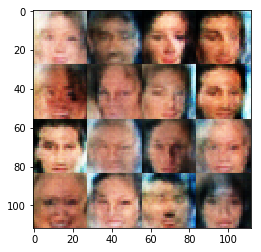

Epoch 0/2... Discriminator Loss: 1.1393... Generator Loss: 0.6250
Epoch 0/2... Discriminator Loss: 0.8749... Generator Loss: 1.2816
Epoch 0/2... Discriminator Loss: 1.0994... Generator Loss: 0.7398
Epoch 0/2... Discriminator Loss: 1.0462... Generator Loss: 1.6112
Epoch 0/2... Discriminator Loss: 0.7972... Generator Loss: 1.3746


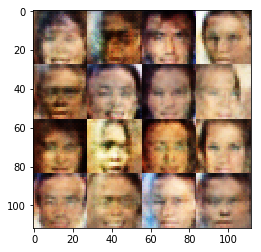

Epoch 0/2... Discriminator Loss: 0.7899... Generator Loss: 1.1073
Epoch 0/2... Discriminator Loss: 0.8765... Generator Loss: 0.9548
Epoch 0/2... Discriminator Loss: 0.6639... Generator Loss: 1.1469
Epoch 0/2... Discriminator Loss: 0.8824... Generator Loss: 1.5516
Epoch 0/2... Discriminator Loss: 0.8578... Generator Loss: 0.9551


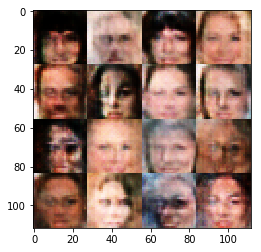

Epoch 0/2... Discriminator Loss: 1.4554... Generator Loss: 0.3852
Epoch 0/2... Discriminator Loss: 0.7939... Generator Loss: 1.4485
Epoch 0/2... Discriminator Loss: 1.0831... Generator Loss: 0.7719
Epoch 0/2... Discriminator Loss: 0.8611... Generator Loss: 1.8756
Epoch 0/2... Discriminator Loss: 0.9124... Generator Loss: 1.2338


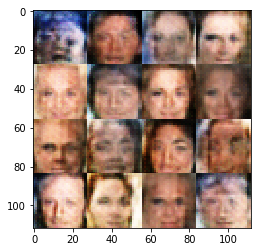

Epoch 0/2... Discriminator Loss: 0.9259... Generator Loss: 1.8713
Epoch 0/2... Discriminator Loss: 1.6287... Generator Loss: 0.3223
Epoch 0/2... Discriminator Loss: 0.9476... Generator Loss: 1.0152
Epoch 0/2... Discriminator Loss: 0.7824... Generator Loss: 1.1215
Epoch 0/2... Discriminator Loss: 0.8855... Generator Loss: 1.0004


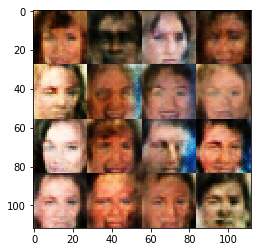

Epoch 0/2... Discriminator Loss: 0.9415... Generator Loss: 0.8517
Epoch 0/2... Discriminator Loss: 1.2083... Generator Loss: 2.0023
Epoch 0/2... Discriminator Loss: 0.9851... Generator Loss: 0.7121
Epoch 0/2... Discriminator Loss: 0.6562... Generator Loss: 1.3943
Epoch 0/2... Discriminator Loss: 0.8348... Generator Loss: 1.9971


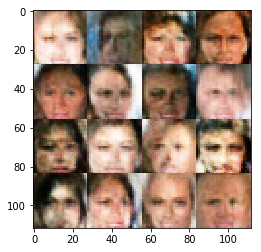

Epoch 0/2... Discriminator Loss: 0.7256... Generator Loss: 1.4833
Epoch 0/2... Discriminator Loss: 1.0445... Generator Loss: 0.7110
Epoch 0/2... Discriminator Loss: 1.4158... Generator Loss: 0.4034
Epoch 0/2... Discriminator Loss: 0.8608... Generator Loss: 1.0582
Epoch 0/2... Discriminator Loss: 0.7811... Generator Loss: 1.3562


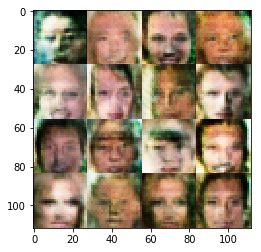

Epoch 0/2... Discriminator Loss: 0.8844... Generator Loss: 1.5555
Epoch 0/2... Discriminator Loss: 0.7666... Generator Loss: 1.3607
Epoch 0/2... Discriminator Loss: 1.1179... Generator Loss: 0.6549
Epoch 0/2... Discriminator Loss: 0.8739... Generator Loss: 1.1476
Epoch 0/2... Discriminator Loss: 1.1116... Generator Loss: 0.7316


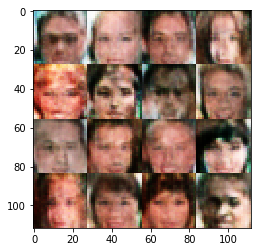

Epoch 0/2... Discriminator Loss: 1.0610... Generator Loss: 0.6817
Epoch 0/2... Discriminator Loss: 1.3477... Generator Loss: 0.4383
Epoch 0/2... Discriminator Loss: 1.1881... Generator Loss: 0.6005
Epoch 0/2... Discriminator Loss: 1.0375... Generator Loss: 0.6886
Epoch 0/2... Discriminator Loss: 0.8476... Generator Loss: 1.3257


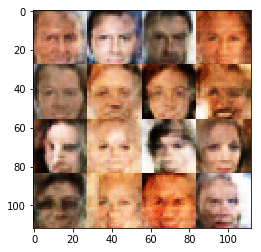

Epoch 0/2... Discriminator Loss: 1.3995... Generator Loss: 0.4354
Epoch 0/2... Discriminator Loss: 0.7091... Generator Loss: 1.3505
Epoch 0/2... Discriminator Loss: 0.9669... Generator Loss: 2.1187
Epoch 0/2... Discriminator Loss: 1.3069... Generator Loss: 2.0553
Epoch 0/2... Discriminator Loss: 1.0266... Generator Loss: 0.7366


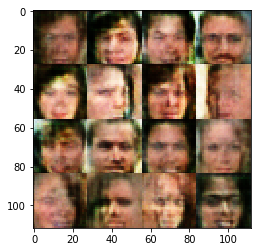

Epoch 0/2... Discriminator Loss: 1.1741... Generator Loss: 0.5887
Epoch 0/2... Discriminator Loss: 0.8753... Generator Loss: 0.8383
Epoch 0/2... Discriminator Loss: 0.9793... Generator Loss: 0.8180
Epoch 0/2... Discriminator Loss: 0.8530... Generator Loss: 1.3313
Epoch 0/2... Discriminator Loss: 0.7264... Generator Loss: 0.9997


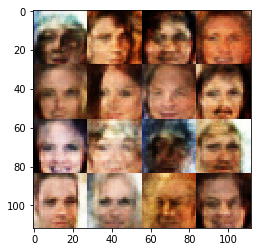

Epoch 0/2... Discriminator Loss: 0.7227... Generator Loss: 1.7443
Epoch 0/2... Discriminator Loss: 0.7034... Generator Loss: 1.1106
Epoch 0/2... Discriminator Loss: 1.0845... Generator Loss: 0.9427
Epoch 0/2... Discriminator Loss: 1.0742... Generator Loss: 1.5094
Epoch 0/2... Discriminator Loss: 1.4469... Generator Loss: 0.4357


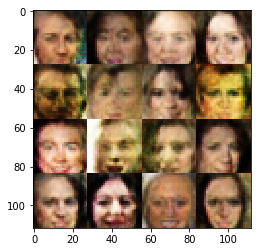

Epoch 0/2... Discriminator Loss: 0.7237... Generator Loss: 1.2646
Epoch 0/2... Discriminator Loss: 0.7770... Generator Loss: 1.0183
Epoch 0/2... Discriminator Loss: 1.0648... Generator Loss: 0.5950
Epoch 0/2... Discriminator Loss: 0.9839... Generator Loss: 1.3334
Epoch 0/2... Discriminator Loss: 0.9734... Generator Loss: 0.7740


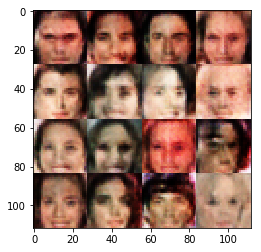

Epoch 0/2... Discriminator Loss: 0.9307... Generator Loss: 0.9200
Epoch 0/2... Discriminator Loss: 1.3709... Generator Loss: 0.4326
Epoch 0/2... Discriminator Loss: 0.8706... Generator Loss: 0.8643
Epoch 0/2... Discriminator Loss: 0.8558... Generator Loss: 1.2366
Epoch 0/2... Discriminator Loss: 1.0146... Generator Loss: 0.7926


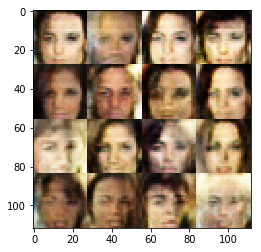

Epoch 0/2... Discriminator Loss: 0.9807... Generator Loss: 0.7331
Epoch 0/2... Discriminator Loss: 1.0109... Generator Loss: 1.9386
Epoch 0/2... Discriminator Loss: 1.1045... Generator Loss: 1.1620
Epoch 0/2... Discriminator Loss: 0.9757... Generator Loss: 0.8693
Epoch 0/2... Discriminator Loss: 0.8964... Generator Loss: 1.4024


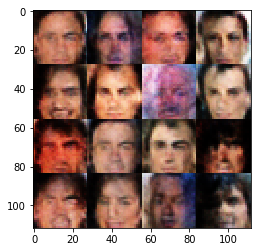

Epoch 0/2... Discriminator Loss: 0.8095... Generator Loss: 1.7142
Epoch 0/2... Discriminator Loss: 0.9500... Generator Loss: 0.8505
Epoch 0/2... Discriminator Loss: 0.9883... Generator Loss: 0.9309
Epoch 0/2... Discriminator Loss: 0.8389... Generator Loss: 1.0302
Epoch 0/2... Discriminator Loss: 0.7669... Generator Loss: 1.6289


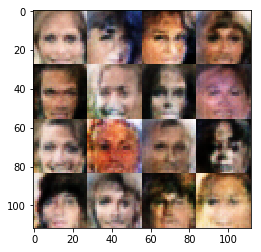

Epoch 0/2... Discriminator Loss: 0.8748... Generator Loss: 1.7123
Epoch 0/2... Discriminator Loss: 1.0381... Generator Loss: 0.7200
Epoch 0/2... Discriminator Loss: 1.0177... Generator Loss: 0.7129
Epoch 0/2... Discriminator Loss: 1.0160... Generator Loss: 0.7522
Epoch 0/2... Discriminator Loss: 0.9119... Generator Loss: 1.5784


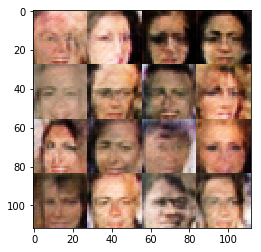

Epoch 0/2... Discriminator Loss: 0.9595... Generator Loss: 0.8747
Epoch 0/2... Discriminator Loss: 1.0857... Generator Loss: 1.2146
Epoch 0/2... Discriminator Loss: 0.9797... Generator Loss: 0.8820
Epoch 0/2... Discriminator Loss: 0.8710... Generator Loss: 0.9297
Epoch 0/2... Discriminator Loss: 0.9066... Generator Loss: 1.0325


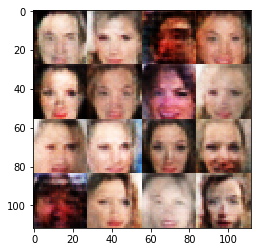

Epoch 0/2... Discriminator Loss: 1.0983... Generator Loss: 0.6056
Epoch 0/2... Discriminator Loss: 0.9469... Generator Loss: 1.8376
Epoch 0/2... Discriminator Loss: 0.7405... Generator Loss: 1.1531
Epoch 0/2... Discriminator Loss: 1.0642... Generator Loss: 0.7852
Epoch 0/2... Discriminator Loss: 1.2671... Generator Loss: 1.6600


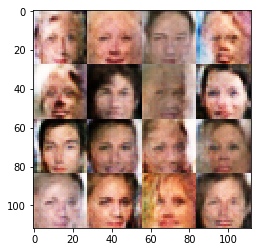

Epoch 0/2... Discriminator Loss: 0.9604... Generator Loss: 1.3895
Epoch 0/2... Discriminator Loss: 0.8780... Generator Loss: 1.1473
Epoch 0/2... Discriminator Loss: 1.3865... Generator Loss: 0.3947
Epoch 0/2... Discriminator Loss: 1.6439... Generator Loss: 2.8956
Epoch 0/2... Discriminator Loss: 0.9865... Generator Loss: 0.8339


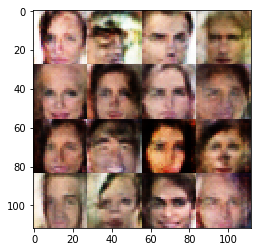

Epoch 0/2... Discriminator Loss: 0.9663... Generator Loss: 0.7810
Epoch 0/2... Discriminator Loss: 0.9055... Generator Loss: 1.0324
Epoch 0/2... Discriminator Loss: 0.8470... Generator Loss: 1.5972
Epoch 0/2... Discriminator Loss: 1.1033... Generator Loss: 1.7344
Epoch 0/2... Discriminator Loss: 1.0154... Generator Loss: 2.2608


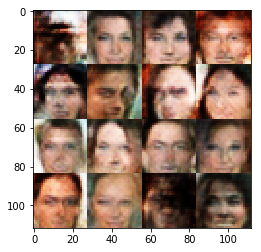

Epoch 0/2... Discriminator Loss: 0.9148... Generator Loss: 1.3402
Epoch 0/2... Discriminator Loss: 0.8058... Generator Loss: 0.9557
Epoch 0/2... Discriminator Loss: 0.8705... Generator Loss: 0.8207
Epoch 0/2... Discriminator Loss: 0.7845... Generator Loss: 0.9301
Epoch 0/2... Discriminator Loss: 0.7282... Generator Loss: 1.0051


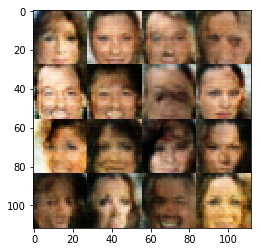

Epoch 0/2... Discriminator Loss: 1.2564... Generator Loss: 2.5057
Epoch 0/2... Discriminator Loss: 0.9290... Generator Loss: 0.8381
Epoch 0/2... Discriminator Loss: 0.8074... Generator Loss: 0.8250
Epoch 0/2... Discriminator Loss: 1.0255... Generator Loss: 1.6490
Epoch 0/2... Discriminator Loss: 0.7756... Generator Loss: 1.1974


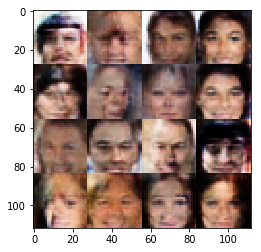

Epoch 0/2... Discriminator Loss: 0.9834... Generator Loss: 0.7982
Epoch 0/2... Discriminator Loss: 1.0301... Generator Loss: 0.6757
Epoch 0/2... Discriminator Loss: 0.8729... Generator Loss: 0.8917
Epoch 0/2... Discriminator Loss: 0.9623... Generator Loss: 0.8620
Epoch 0/2... Discriminator Loss: 1.2557... Generator Loss: 0.5251


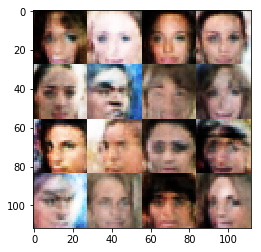

Epoch 0/2... Discriminator Loss: 1.2326... Generator Loss: 0.5336
Epoch 0/2... Discriminator Loss: 1.1603... Generator Loss: 0.5875
Epoch 0/2... Discriminator Loss: 0.9141... Generator Loss: 1.5184
Epoch 0/2... Discriminator Loss: 0.8142... Generator Loss: 1.1513
Epoch 0/2... Discriminator Loss: 0.8821... Generator Loss: 0.9972


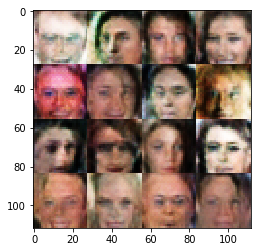

Epoch 0/2... Discriminator Loss: 0.9794... Generator Loss: 0.9502
Epoch 0/2... Discriminator Loss: 0.8828... Generator Loss: 1.0631
Epoch 0/2... Discriminator Loss: 0.9395... Generator Loss: 0.9189
Epoch 0/2... Discriminator Loss: 1.1107... Generator Loss: 0.6372
Epoch 0/2... Discriminator Loss: 1.0000... Generator Loss: 0.7629


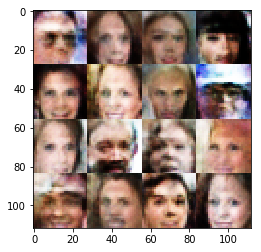

Epoch 0/2... Discriminator Loss: 0.8455... Generator Loss: 1.0288
Epoch 0/2... Discriminator Loss: 0.8665... Generator Loss: 1.2775
Epoch 0/2... Discriminator Loss: 1.3979... Generator Loss: 0.4280
Epoch 0/2... Discriminator Loss: 0.8364... Generator Loss: 0.9378
Epoch 0/2... Discriminator Loss: 1.0614... Generator Loss: 0.6692


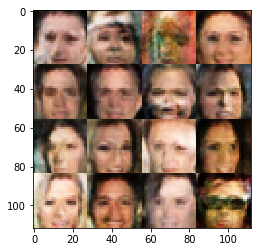

Epoch 0/2... Discriminator Loss: 1.0068... Generator Loss: 0.7420
Epoch 0/2... Discriminator Loss: 1.0486... Generator Loss: 0.6009
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.4348
Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.5789


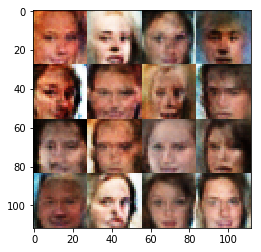

Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.4639
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.1628


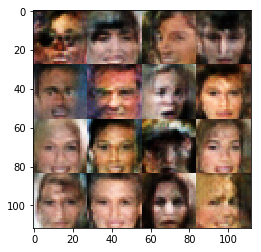

Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 1.5129
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.1910
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 2.0386
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 0.6517


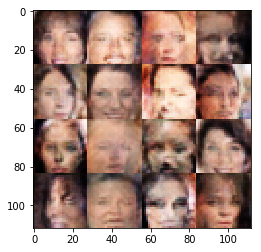

Epoch 1/2... Discriminator Loss: 0.8871... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 1.6345... Generator Loss: 0.3102
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 1.1799
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 0.9830... Generator Loss: 0.7100


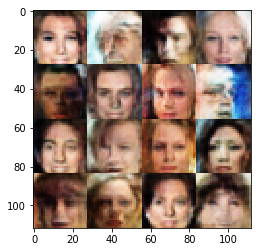

Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 2.0459
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.8406
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.4717


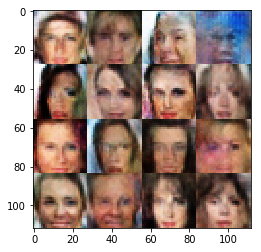

Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 0.7085... Generator Loss: 1.3404
Epoch 1/2... Discriminator Loss: 0.8324... Generator Loss: 1.1552
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.3765
Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 0.5465


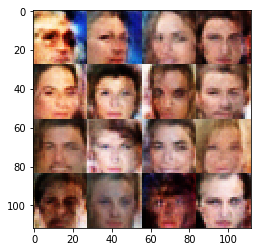

Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 0.9794
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 0.7083
Epoch 1/2... Discriminator Loss: 0.7857... Generator Loss: 1.1379


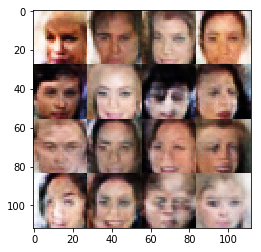

Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 1.3858


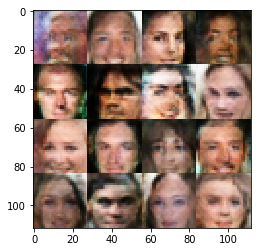

Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.5868
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 0.5657


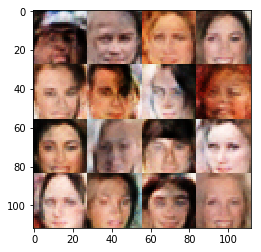

Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.7462
Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 1.3371


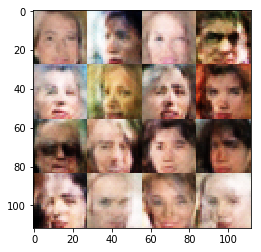

Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 1.4092
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 2.2838
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.4408


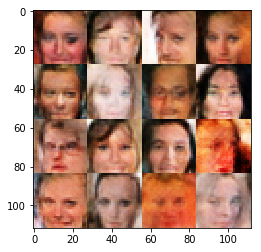

Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 2.1017
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 1.4149
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 1.1023
Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 1.1089


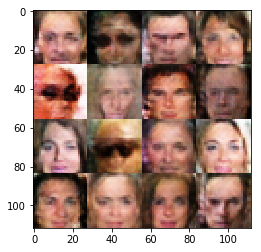

Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.0942
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 0.9334
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.1555
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 1.0599


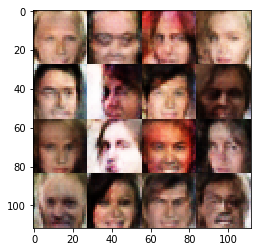

Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.2306
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 1.1796
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 0.9257
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.4793


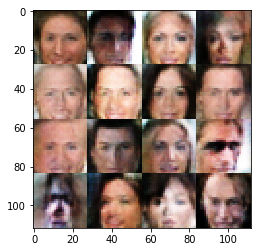

Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 1.4537
Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 1.1730
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 0.8564


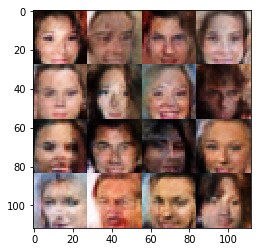

Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.8306


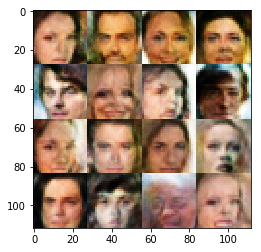

Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 0.9471
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 1.6734
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.4440
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 0.8415


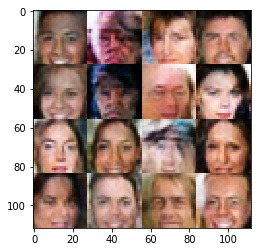

Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.4974
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.0664
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 0.8446
Epoch 1/2... Discriminator Loss: 1.1065... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 1.0635


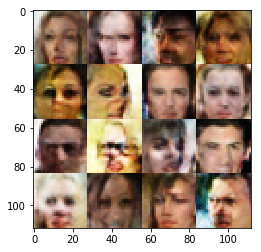

Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 1.4535
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.4741
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 1.3578
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 1.4777
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.0121


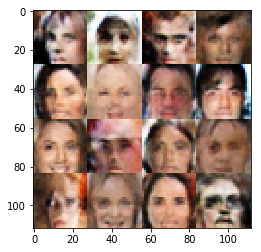

Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 1.8426
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.5494


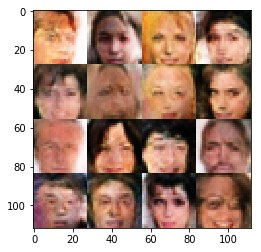

Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 1.9539
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 1.5102
Epoch 1/2... Discriminator Loss: 0.9247... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.6418


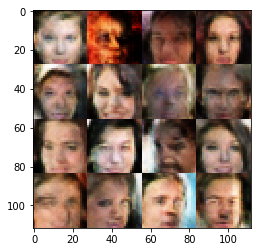

Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.3787
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 0.8341... Generator Loss: 1.3637


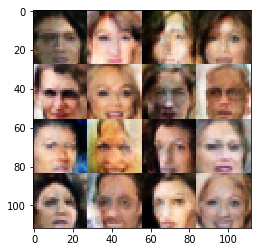

Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 1.4355
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 0.7679
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 0.8586


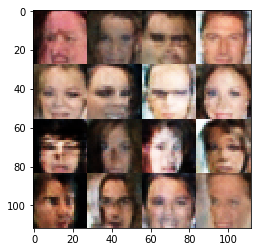

Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 1.1732
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 0.9411


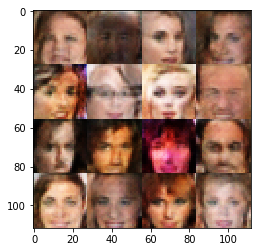

Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 1.6569
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 0.9853
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.6415


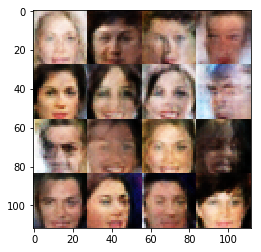

Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 0.9853
Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 0.8187
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 2.5569


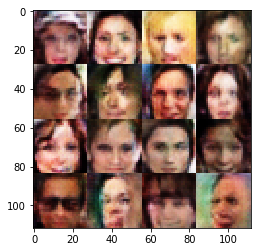

Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 0.8016... Generator Loss: 1.3047
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 1.8348
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.5139


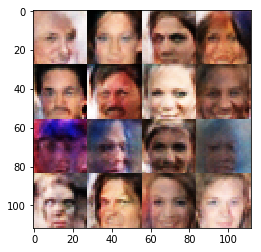

Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 1.3384
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 1.6226
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 1.1789


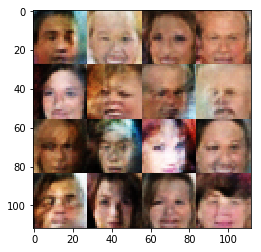

Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 1.3382
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.8554
Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 1.1858
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 2.3744


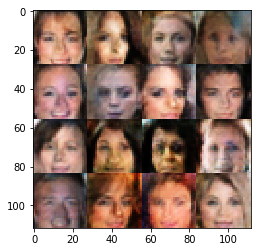

Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 1.5563
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 1.7032
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.6860
Epoch 1/2... Discriminator Loss: 0.7920... Generator Loss: 1.1544


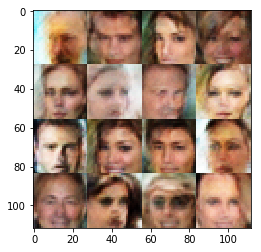

Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 1.0136
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 0.9781
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 1.3240


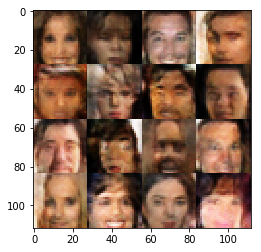

Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 1.2542
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.9371
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 0.8516


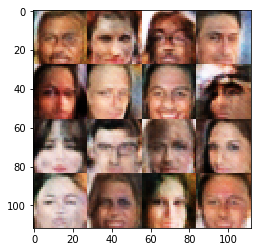

Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 1.0653
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.3500
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 0.9244
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.7376


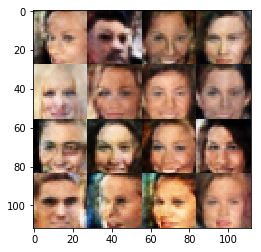

Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 0.7781
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.8834
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.7335
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 1.2089


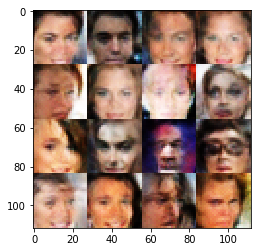

Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 1.3112
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.3793


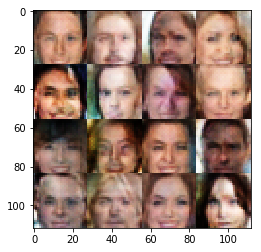

Epoch 1/2... Discriminator Loss: 1.6754... Generator Loss: 0.2852
Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.3486
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 0.9818
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.3669


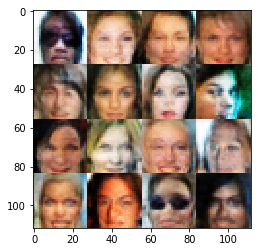

Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.2988
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 1.3270
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 0.7937


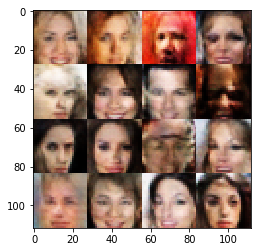

Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.3964
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.5331


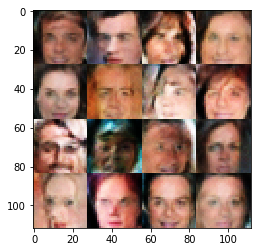

Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 1.0699... Generator Loss: 1.2693
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.4101


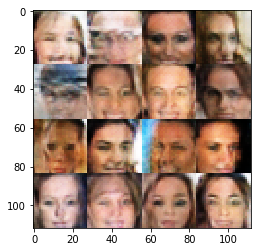

Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 0.9285
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.6839


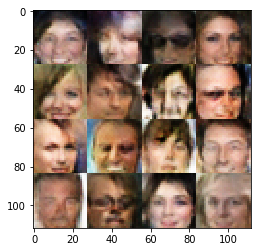

Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.4048


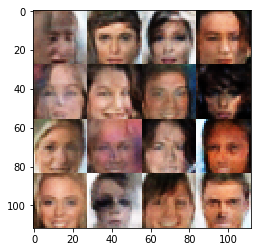

Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.4273
Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 0.3153
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.7712


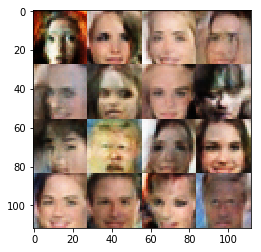

Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.9442
Epoch 1/2... Discriminator Loss: 0.8165... Generator Loss: 0.9952


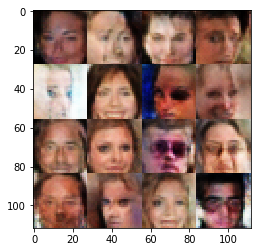

Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 1.4624
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.3739
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 0.9321... Generator Loss: 1.1942


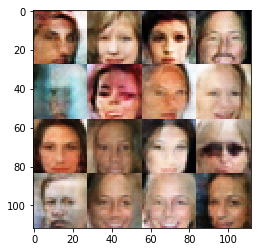

Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 0.9150
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 0.9414
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.1396


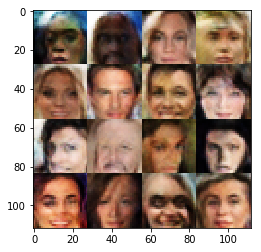

Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 0.9763
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.7674
Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 1.6647
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 1.6656


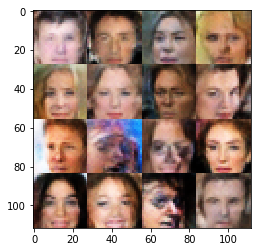

Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.4939
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 0.7059
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.6681
Epoch 1/2... Discriminator Loss: 1.1096... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 0.9536


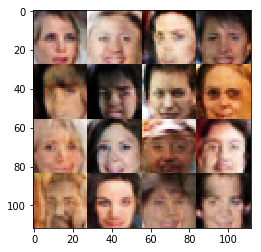

Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 0.5624
Epoch 1/2... Discriminator Loss: 1.1929... Generator Loss: 0.5439
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.8222


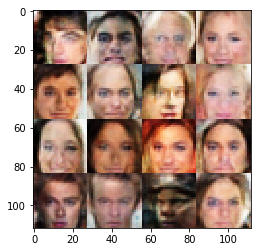

Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 1.3466
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.5672
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 0.8628
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 1.1171
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 0.8655


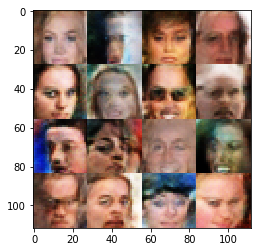

Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.5070
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.4544
Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 1.3151


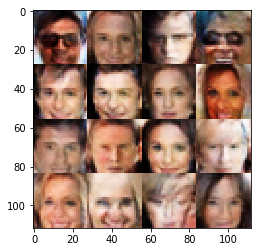

Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 0.4616
Epoch 1/2... Discriminator Loss: 0.8962... Generator Loss: 1.1531
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 0.9626


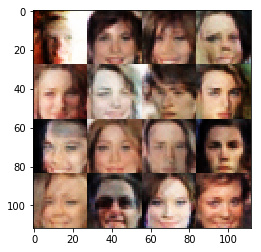

Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.5511
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.5148
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.3976
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 1.1351
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.4174


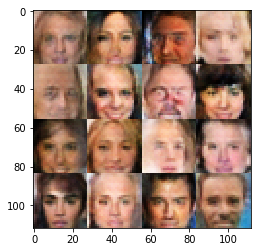

Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 0.3371
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.0512
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 1.0521


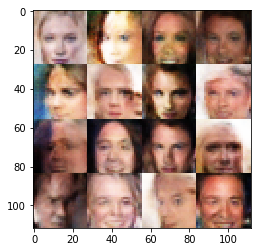

Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 1.1953
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 0.9391
Epoch 1/2... Discriminator Loss: 1.0823... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 2.6362
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.4712


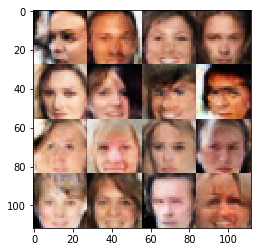

Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.3070
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 0.8825
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 1.0563
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 0.7493


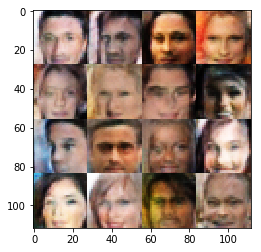

Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 0.7402... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 0.8782


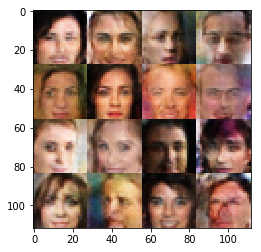

Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 1.0937
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 0.5408
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 1.0325
Epoch 1/2... Discriminator Loss: 0.9794... Generator Loss: 0.8592


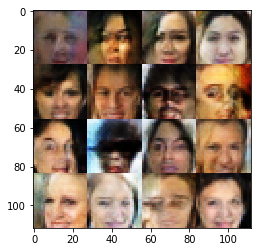

Epoch 1/2... Discriminator Loss: 1.2244... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.1655
Epoch 1/2... Discriminator Loss: 0.5940... Generator Loss: 1.5787
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.6691


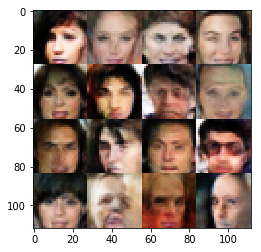

Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 1.2197
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 0.6242


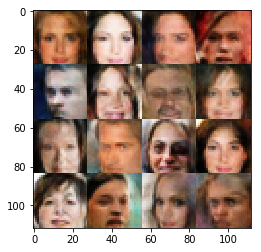

Epoch 1/2... Discriminator Loss: 1.4905... Generator Loss: 0.3520
Epoch 1/2... Discriminator Loss: 1.0276... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.1836
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.1921
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 1.4311


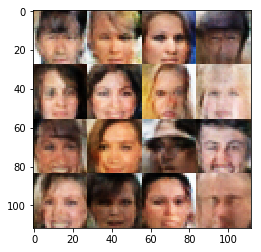

Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.3124
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.1425
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.4452
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 0.3791
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 0.8016


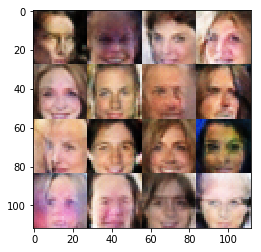

Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 0.7498
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.4056
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 1.3754


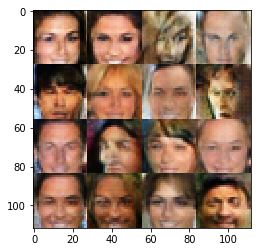

Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 1.0265
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.6005
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 0.7180... Generator Loss: 1.0736
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 1.0950


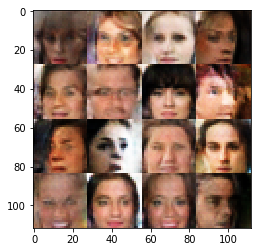

Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 0.9968... Generator Loss: 0.9398
Epoch 1/2... Discriminator Loss: 1.1007... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.5721


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.